# 07 - 超越混杂因素


## 有效控制变量

我们已经了解到，在回归模型中添加额外的控制变量有助于识别因果效应。若控制变量为混杂因素，将其纳入模型不仅是锦上添花，更是必要条件。当缺乏经验者见此情形，常会本能地将所有可测变量塞入模型。在当今大数据时代，这轻易就能超过 1000 个变量。事实证明，这不仅无必要，反而可能损害因果识别。现在，我们将关注点转向非混杂因素的控制变量。首先探讨有益的控制变量，随后再深入剖析有害的控制变量。

以一个激励性案例为例，假设你是某金融科技公司催收团队的数据科学家。你的下一项任务是评估发送债务协商邮件的影响。你的响应变量是逾期客户的还款金额。

为解答此问题，您的团队从逾期客户库中随机选取 5000 名客户进行一项随机测试。对每位客户，您抛掷硬币决定：若为正面，则向该客户发送邮件；反之，则将其留作对照组。通过此测试，您期望量化该邮件能额外产生多少收益。

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr

style.use("fivethirtyeight")

In [2]:
data = pd.read_csv("./data/collections_email.csv")
data.head()

,payments,email,opened,agreement,credit_limit,risk_score
0,740,1,1.0,0.0,2348.495260,0.666752
1,580,1,1.0,1.0,334.111969,0.207395
2,600,1,1.0,1.0,1360.660722,0.550479
3,770,0,0.0,0.0,1531.828576,0.560488
4,660,0,0.0,0.0,979.855647,0.455140


由于数据是随机生成的，可知简单的均值差异即可估计平均处理效应。换言之，除了随机分配外，没有任何因素能导致处理，因此潜在结果独立于处理：$(Y_0, Y_1)\perp T$。 

$
ATE = E[Y|T=1] - E[Y|T=0]
$

鉴于你足够聪明，并希望为估计值设置一个置信区间，于是采用了线性回归方法。

In [3]:
print("Difference in means:",
      data.query("email==1")["payments"].mean() - data.query("email==0")["payments"].mean())

model = smf.ols('payments ~ email', data=data).fit()
model.summary().tables[1]

Difference in means: -0.6202804021329484


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,669.9764,2.061,325.116,0.000,665.937,674.016
email,-0.6203,2.941,-0.211,0.833,-6.387,5.146


遗憾的是，估算的平均处理效应（ATE）为-0.62，这一结果相当反常。发送电子邮件怎会导致逾期客户的付款金额低于平均水平？不过，由于 P 值过高，这一结果可能并无实际意义。接下来你该怎么做？是垂头丧气地回到团队宣布测试无定论、需要更多数据？且慢。

注意你的数据中还包含其他有趣的列。例如， `credit_limit` 代表客户逾期前的信用额度， `risk_score` 对应邮件发送前对客户风险的评估值。可以合理推测，信用额度和风险等级很可能是预测还款情况的有效指标。但这些信息如何发挥作用呢？

首先，我们需要理解为何即使处理效果确实存在，我们仍可能无法在统计上发现其显著性。原因或许如本例所示，处理对结果的影响微乎其微。细想之下，促使人们偿还债务的主要因素大多超出了催收部门的控制范围——人们还款是因为找到了新工作、改善了财务状况或收入等。用统计学术语来说，**付款行为的变异性更多是由电子邮件之外的其他因素所解释的**。

为了直观理解这一点，我们可以绘制付款金额与处理变量（电子邮件）的散点图。图中红色线条展示了模型的拟合线。为增强可视化效果，我在电子邮件变量中加入了少量噪声，以避免数据点完全集中在 0 或 1 的位置。

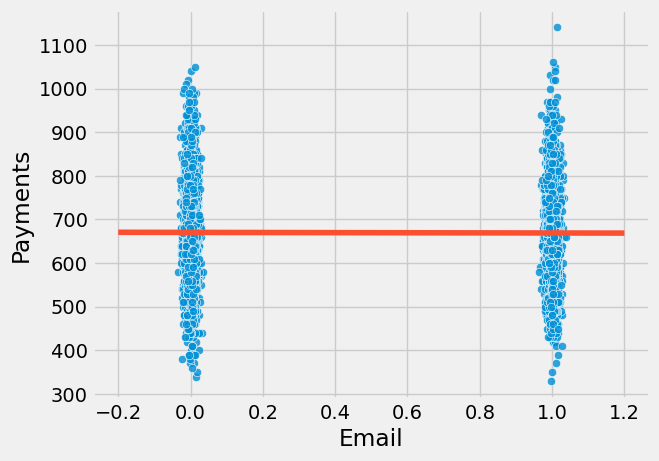

In [4]:
sns.scatterplot(x="email", y="payments", 
                alpha=0.8,
                data=data.assign(email=data["email"] + np.random.normal(0, 0.01, size=len(data["email"]))))
plt.plot(np.linspace(-0.2, 1.2), model.params[0] + np.linspace(-1, 2) * model.params[1], c="C1")
plt.xlabel("Email")
plt.ylabel("Payments");

从图中可见，单一处理组内的付款金额波动极为剧烈。视觉上，两组数据都呈现出从略低于 400 到 1000 的大幅跨度。如果电子邮件的影响仅在 5.00 或 10.00 雷亚尔量级，那么在如此巨大的变异性中难以察觉其作用也就不足为奇了。

幸运的是，回归分析能帮助我们降低这种变异性。关键在于运用额外的控制变量。**若某一变量能有效预测结果，它将解释结果中的大量方差**。如果风险和信用额度是付款行为的良好预测指标，通过控制这些变量，我们便能更轻松地识别电子邮件对付款行为的影响。回顾回归分析的工作原理，这一点便有了直观的解释。在回归模型中添加额外变量意味着在考察处理效应时保持这些变量恒定。因此，逻辑上，当我们观察风险和信用额度水平相近的客户时，响应变量 `payments` 的方差应当更小。换言之，若风险和信用额度能准确预测付款行为，那么具有相似风险和信用额度的客户其付款水平也应相近，从而展现出更小的方差。

![img](./images/07/y-pred.png)

为了说明这一点，我们采用部分剔除的方法将回归分解为两个步骤。首先，我们将处理变量（电子邮件）和结果变量（付款）对额外控制变量（信用额度和风险评分）进行回归。接着，在第一步得到的基础上，我们将处理变量的残差对付款的残差进行回归。（这纯粹是教学性质的，实际操作中无需如此繁琐）。

In [5]:
model_email = smf.ols('email ~ credit_limit + risk_score', data=data).fit()
model_payments = smf.ols('payments ~ credit_limit + risk_score', data=data).fit()

residuals = pd.DataFrame(dict(res_payments=model_payments.resid, res_email=model_email.resid))

model_treatment = smf.ols('res_payments ~ res_email', data=residuals).fit()

这降低了因变量的方差。通过将支付金额对信用额度和风险进行回归并获取该模型的残差，我们创建了一个比原始变量变异性小得多的新因变量。最后一个模型还揭示了具有有效标准误差估计的 `ATE` 。

出于好奇，我们还可以验证预测处理方式的模型不应能降低其方差。这是因为邮件设计上就是随机的，因此无法被任何因素预测。

In [6]:
print("Payments Variance", np.var(data["payments"]))
print("Payments Residual Variance", np.var(residuals["res_payments"]))

print("Email Variance", np.var(data["email"]))
print("Email Residual Variance", np.var(residuals["res_email"]))

model_treatment.summary().tables[1]

Payments Variance 10807.61241599994
Payments Residual Variance 5652.453558466198
Email Variance 0.24991536000001294
Email Residual Variance 0.24918421069820032


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.061e-13,1.063,9.98e-14,1.000,-2.084,2.084
res_email,4.4304,2.129,2.080,0.038,0.256,8.605


注意到支付金额的方差从 10807 降至 5652。在控制了风险和信用额度后，我们几乎将其减少了一半。同时也要注意到，我们未能降低处理邮件的变异性。这是合理的，因为风险和信用额度并不能预测邮件（根据随机性的定义，没有任何因素可以做到）。

现在，我们看到了更为合理的结果。这一新的估计值告诉我们，预计收到邮件的顾客平均比对照组多支付 4.4 雷亚尔。此估计值如今在统计上显著区别于零。我们还可以观察到各对照组内的方差现在有所降低。

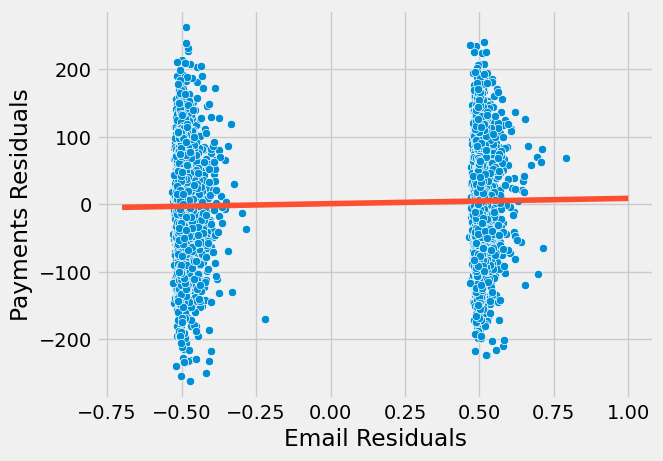

In [7]:
sns.scatterplot(x="res_email", y="res_payments", data=residuals)
plt.plot(np.linspace(-0.7, 1), model_treatment.params[0] + np.linspace(-1, 2) * model_treatment.params[1], c="C1")
plt.xlabel("Email Residuals")
plt.ylabel("Payments Residuals");

如前所述，我们这样做是出于教学目的。实际操作中，您只需将控制变量与处理变量一同加入回归模型，所得估计值将完全相同。

In [8]:
model_2 = smf.ols('payments ~ email + credit_limit + risk_score', data=data).fit()
model_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,490.8653,9.715,50.527,0.000,471.820,509.911
email,4.4304,2.130,2.080,0.038,0.255,8.606
credit_limit,0.1511,0.008,18.833,0.000,0.135,0.167
risk_score,-8.0516,38.424,-0.210,0.834,-83.379,67.276


总结来说，任何时候如果我们有一个对结果有良好预测性的控制变量，即便它不是混杂因素，将其纳入模型都是明智之举。这有助于降低我们处理效应估计的方差。以下是这种情况在因果图中的示意图。

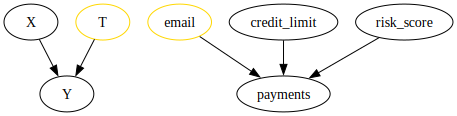

In [9]:
g = gr.Digraph()
g.edge("X", "Y"), g.edge("T", "Y")
g.node("T", color="gold")

g.node("email", color="gold")
g.edge("credit_limit", "payments")
g.edge("risk_score", "payments")
g.edge("email", "payments")

g

## 多数有害的控制变量

作为第二个激励性例子，让我们考虑一个涉及两家医院的药物测试场景。这两家医院都在对一种处理特定疾病的新药进行随机试验，关注的结果是住院天数。若处理有效，将减少患者的住院时间。其中一家医院的政策是向 90%的患者提供真实药物，而 10%接受安慰剂；另一家医院则采取不同策略：随机为 10%的患者提供药物，其余 90%接受安慰剂。你还被告知，通常给予 90%真实药物和 10%安慰剂的那家医院接收的病例病情更为严重。

In [10]:
hospital = pd.read_csv("./data/hospital_treatment.csv")
hospital.head()

,hospital,treatment,severity,days
0,1,1,29.686618,82
1,1,1,20.050340,57
2,1,1,20.302399,49
3,0,0,10.603118,44
4,0,0,8.332793,15


由于你正在处理随机化数据，你的第一反应是简单地对结果与处理进行回归分析。

In [11]:
hosp_1 = smf.ols('days ~ treatment', data=hospital).fit()
hosp_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,33.2667,2.662,12.498,0.000,27.968,38.566
treatment,14.1533,3.367,4.204,0.000,7.451,20.856


但你发现了一些反直觉的结果。处理为何会增加住院天数？答案在于我们实际上在进行两项不同的实验。病情严重程度与住院时间呈正相关，而由于收治重症患者更多的医院也倾向于使用更多药物，药物便与更长的住院时间产生了正相关。当我们综合考察两家医院时，发现 $E[Y_0|T=0]<E[Y_0|T=1]$ ——即未接受处理者的潜在结局平均低于接受处理者，因为轻症医院中未处理患者比例更高。换言之，病情严重程度作为混杂因素，既决定了患者入住的医院，也影响了接受药物处理的概率。

解决这个问题有两种方法。第一种是单独查看每家医院的 ATE，但这违背了利用两家医院数据的初衷。

In [12]:
hosp_2 = smf.ols('days ~ treatment', data=hospital.query("hospital==0")).fit()
hosp_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,30.4074,2.868,10.602,0.000,24.523,36.292
treatment,-11.4074,10.921,-1.045,0.306,-33.816,11.001


In [13]:
hosp_3 = smf.ols('days ~ treatment', data=hospital.query("hospital==1")).fit()
hosp_3.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,59.0000,6.747,8.745,0.000,45.442,72.558
treatment,-10.3958,6.955,-1.495,0.141,-24.371,3.580


在这种情况下，我们确实得到了平均处理效应（ATE）的直观结果。看起来现在药物实际上减少了住院天数。然而，由于我们分别考察每家医院的数据，数据点不足，因此无法得出具有统计学显著性的结果。

另一种方法是利用回归的力量，通过将严重程度纳入模型来控制它。

In [14]:
hosp_4 = smf.ols('days ~ treatment + severity', data=hospital).fit()
hosp_4.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.6641,2.000,5.832,0.000,7.681,15.647
treatment,-7.5912,2.269,-3.345,0.001,-12.110,-3.073
severity,2.2741,0.154,14.793,0.000,1.968,2.580


接下来出现的问题是，我们是否也应该将医院纳入模型中？毕竟，我们知道医院决定了处理方式，对吧？确实如此，但一旦我们控制了病情严重程度，医院与住院天数这一结果就不再相关。而我们知道，要成为混杂因素，变量必须同时影响处理和结果。在此案例中，我们有一个仅影响处理的变量。

但或许控制它确实能降低方差，对吧？然而，事实并非如此。要使控制变量能降低方差，它必须是对结果而非处理有良好预测性的变量，而此处的情况恰恰相反。

不过，我们或许还是想控制它，对吧？这总不会有坏处……还是说，真的会有？

In [15]:
hosp_5 = smf.ols('days ~ treatment + severity + hospital', data=hospital).fit()
hosp_5.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.0111,2.118,5.198,0.000,6.792,15.230
treatment,-5.0945,3.492,-1.459,0.149,-12.049,1.861
severity,2.3865,0.195,12.251,0.000,1.999,2.774
hospital,-4.1535,4.413,-0.941,0.350,-12.943,4.636


出乎意料的是，可能真的有坏处！

![img](./images/07/shocked.png)

在严重程度之上增加医院作为控制变量，反而给我们的平均处理效应（ATE）估计量引入了更多的方差。这是怎么回事？答案在于回归系数标准误的公式中。

$
\hat{\sigma}^2 = \dfrac{1}{n-2} \sum( y_i - \hat{y}_i )^2
$

$
\text{Var}(\hat{\beta}_2) = \dfrac{\sigma^2}{\sum(x_i - \bar{x})^2}
$

从该公式可以看出，标准误差与变量 $X$ 的方差成反比。这意味着，如果 $X$ 变化不大，将难以估计其对结果的影响。这一点在直觉上也讲得通。举个极端例子，假设你想评估某种药物的效果，于是对 10000 人进行测试，但其中仅 1 人接受了处理。这将使寻找平均处理效应（ATE）变得极为困难，我们不得不依赖将单个个体与其余所有人进行比较。换言之，我们需要处理变量存在大量变异，才能更容易发现其影响。

至于为什么将医院纳入模型会增加我们估计的误差，是因为医院是处理的一个良好预测变量，但并不是结果的预测变量（在控制了疾病严重程度之后）。因此，通过预测处理，医院实际上降低了模型的方差！再次地，我们可以将回归模型分解为两个步骤来观察这一点。

In [16]:
model_treatment = smf.ols('treatment ~ severity + hospital', data=hospital).fit()
model_days = smf.ols('days ~ severity + hospital', data=hospital).fit()

residuals = pd.DataFrame(dict(res_days=model_days.resid, res_treatment=model_treatment.resid))

model_treatment = smf.ols('res_days ~ res_treatment', data=residuals).fit()

model_treatment.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.702e-14,0.827,3.27e-14,1.000,-1.646,1.646
res_treatment,-5.0945,3.447,-1.478,0.143,-11.957,1.768


In [17]:
print("Treatment Variance", np.var(hospital["treatment"]))
print("Treatment Residual Variance", np.var(residuals["res_treatment"]))

Treatment Variance 0.234375
Treatment Residual Variance 0.057529091872119076


另外，不必仅听信我的一面之词！你可以自行验证上述 SE 公式的正确性：

In [18]:
sigma_hat = sum(model_treatment.resid**2)/(len(model_treatment.resid)-2)
var = sigma_hat/sum((residuals["res_treatment"] - residuals["res_treatment"].mean())**2)
print("SE of the Coeficient:", np.sqrt(var))

SE of the Coeficient: 3.4469737674869028


所以关键在于，我们应当加入那些既与处理变量又与结果变量相关的控制变量（即混杂因素），如上文模型中的严重程度。同时，也应纳入能良好预测结果变量的控制项，即便它们并非混杂因素，因其有助于降低估计的方差。然而，**切勿**仅因变量能有效预测处理变量就将其加入控制，这反而会增大估计的方差。

这是用因果图表示该情况的示意图。

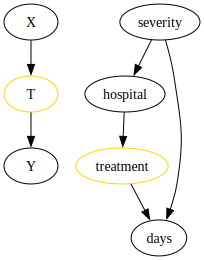

In [19]:
g = gr.Digraph()

g.edge("X", "T"), g.edge("T", "Y")
g.node("T", color="gold")

g.node("treatment", color="gold")
g.edge("severity", "hospital")
g.edge("severity", "days")
g.edge("hospital", "treatment")
g.edge("treatment", "days")

g

## 有害控制变量 - 选择偏误

让我们回到催收邮件的例子。记得邮件是随机分配给客户的。我们已经解释了 `credit_limit` 和 `risk_score` 的含义。现在，来看剩下的变量。 `opened` 是一个虚拟变量，表示客户是否打开了邮件。 `agreement` 是另一个虚拟变量，标记客户在收到邮件后是否联系了催收部门协商债务。你认为以下哪种模型更合适？第一种是包含处理变量加上 `credit_limit` 和 `risk_score` 的模型；第二种则额外加入了 `opened` 和 `agreement` 虚拟变量。

In [20]:
email_1 = smf.ols('payments ~ email + credit_limit + risk_score', data=data).fit()
email_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,490.8653,9.715,50.527,0.000,471.820,509.911
email,4.4304,2.130,2.080,0.038,0.255,8.606
credit_limit,0.1511,0.008,18.833,0.000,0.135,0.167
risk_score,-8.0516,38.424,-0.210,0.834,-83.379,67.276


In [21]:
email_2 = smf.ols('payments ~ email + credit_limit + risk_score + opened + agreement', data=data).fit()
email_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,488.4416,9.716,50.272,0.000,469.394,507.489
email,-1.6095,2.724,-0.591,0.555,-6.949,3.730
credit_limit,0.1507,0.008,18.809,0.000,0.135,0.166
risk_score,-2.0929,38.375,-0.055,0.957,-77.325,73.139
opened,3.9808,3.914,1.017,0.309,-3.692,11.654
agreement,11.7093,4.166,2.811,0.005,3.542,19.876


第一个模型在电子邮件方面发现了统计学上显著的结果，而第二个模型则没有。但或许第二个模型才是正确的，电子邮件实际上并无效果。毕竟，这个模型控制了更多因素，理应更为稳健，对吧？此刻你大概已明白事实并非如此。剩下的问题便是探究真相究竟为何。

我们知道必须加入混杂变量，即那些同时影响处理和结果的变量。我们也清楚，添加能很好预测结果的控制变量是个不错的做法，虽非必须，但有益无害。同样，我们明白仅能预测处理的控制变量不宜加入，这虽非致命错误，但最好避免。那么， `opened` 和 `agreement` 属于哪类控制变量呢？实际上，它们两者皆非上述类型。

仔细想想， `opened` 和 `agreement` 肯定与邮件有关联。毕竟，若未收到邮件，你便无法打开它；而且我们也提到过，协议仅考虑邮件发出后发生的重新协商。但**它们并非导致邮件的原因！相反，它们是由邮件引起的！**

每当我需要理解正在处理的变量类型时，我总是喜欢思考它们的因果图。让我们在这里进行这一过程。

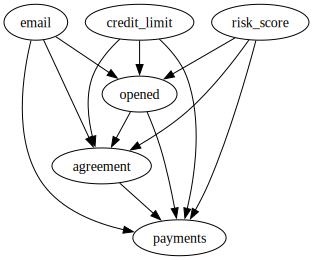

In [22]:
g = gr.Digraph()

g.edge("email", "payments")
g.edge("email", "opened")
g.edge("email", "agreement")
g.edge("opened", "payments")
g.edge("opened", "agreement")
g.edge("agreement", "payments")

g.edge("credit_limit", "payments")
g.edge("credit_limit", "opened")
g.edge("credit_limit", "agreement")
g.edge("risk_score", "payments")
g.edge("risk_score", "opened")
g.edge("risk_score", "agreement")

g

我们明白电子邮件本身并无诱因，因其设计初衷就是随机发送。同时，我们确信（或至少有充分理由相信）信用额度和风险会引发支付行为。此外，我们认为电子邮件确实能促使支付发生。就 `opened` 而言，我们认定它对支付具有因果关系。直观上，打开催收邮件的人更倾向于协商并偿还债务。同理，我们认为 `opened` 能促成协议，原因与促使支付相同。再者，已知 `opened` 由电子邮件触发，且有理由推测不同风险等级和信用额度的人群打开邮件的比率各异，因此信用额度和风险同样影响邮件打开率。至于协议，我们也认为它受 `opened` 驱动。若以支付响应变量为考量，可视其为一个漏斗过程的最终结果：

$
email -> opened -> agreement -> payment 
$

我们还认为，不同风险等级和业务线的个体达成协议的倾向性各异，因此我们也将这些因素标记为促成协议的原因。至于电子邮件与协议的关系，可以提出一种观点，即有些人仅阅读邮件主题便更倾向于作出协议承诺。关键在于，电子邮件即便未经打开阅读，同样可能促成协议的达成。

从这张图表中我们注意到，opened 和 agreement 都处于从 email 到 payments 的因果路径上。因此，如果我们通过回归分析控制这两个变量，相当于在说“这是在保持 `opened` 和 `agreement` 不变的情况下 email 的效果”。然而，这两者都是 email 因果效应的一部分，所以我们不希望固定它们。相反，我们可以认为 email 之所以能增加 payments，正是因为它提高了 agreement 率。如果我们固定这些变量，就会从 email 变量中移除部分真实效应。

利用潜在结果表示法，我们可以说，由于随机化 $E[Y_0|T=0] = E[Y_0|T=1]$。然而，即便存在随机化，当我们控制一致性时，处理组和对照组便不再具有可比性。实际上，通过一些直观的思考，我们甚至能推测出它们之间的差异所在：


$
E[Y_0|T=0, Agreement=0] > E[Y_0|T=1, Agreement=0]
$

$
E[Y_0|T=0, Agreement=1] > E[Y_0|T=1, Agreement=1]
$

第一个方程明确指出，我们认为那些未收到邮件且未达成协议的人比那些收到邮件但未达成协议的人表现更优。这是因为，若处理产生积极效应，那些**即便收到邮件**仍未达成协议的个体在付款方面可能比同样未达成协议且未获得邮件额外激励的个体表现更差。至于第二个方程，那些即使未接受处理也达成协议的个体，可能比那些达成协议但受到邮件额外激励的个体表现更好。

初次阅读时可能会感到非常困惑（至少我是如此），但请务必理解其含义。如有必要，不妨再读一遍。接着，可以对已打开的变量进行类似的推理。尝试自己动手实践。

这种偏误如此普遍，以至于它有了自己的名称。混淆偏误源于未能控制一个共同原因，而选择偏误则是当我们控制了从原因到结果路径上的共同效应或中间变量时产生的。根据经验法则，模型中应始终包含混杂因素和对 $Y$ 有良好预测能力的变量。始终排除仅对 $T$ 有良好预测能力的变量、处理与结果之间的中介变量或处理与结果的共同效应变量。

![img](./images/07/selection.png)

选择偏误如此普遍，以至于连随机化也无法完全消除。更甚者，它常因不当操作而被引入，即便在随机数据中也是如此！识别和避免选择偏误更多依赖于实践而非技巧。它们往往隐藏在某些看似聪明的想法之下，使得揭露它们变得更加困难。以下是我遇到过的一些选择偏误的例子：

    1. 在估计催收策略对付款影响时，添加一个指示变量，用于表示是否支付了全部债务。
    2. 在估计教育对收入的影响时，控制白领与蓝领工作之间的差异。
    3. 在估计利率对贷款期限的影响时，控制转化率。
    4. 在估计孩子对婚外情影响时，控制婚姻幸福感。
    5. 将支付建模 E[Payments] 拆分成两个模型，一个是预测付款是否会发生的二元模型，另一个是预测在某些支付会发生的情况下，支付金额是多少：E[Payments|Payments>0]P(Payments>0)。
    
值得注意的是，所有这些观点听起来都相当合理。选择偏误往往如此。这应被视为一个警示。事实上，在认识到其危害性之前，我自己也曾多次陷入上述陷阱。其中最后一个尤为值得详述，因为它看似巧妙却让许多数据科学家措手不及。这种现象如此普遍，以至于它有了专属名称：**The Bad COP**！

### Bad COP

情况通常如下：你需要预测一个连续变量，但其分布在零值处存在过度集中现象。例如，若建立消费者支出模型，你会得到类似伽马分布但带有大量零值的数据分布。

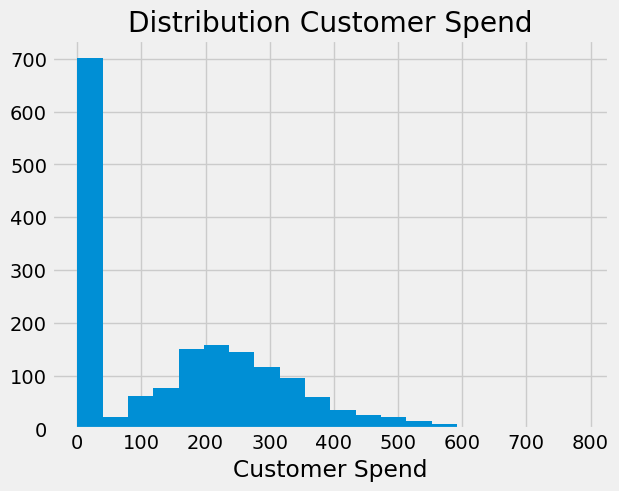

In [23]:
plt.hist(np.concatenate([
    np.random.gamma(5, 50, 1000), 
    np.zeros(700)
]), bins=20)
plt.xlabel("Customer Spend")
plt.title("Distribution Customer Spend");

当数据科学家看到这一点时，脑海中首先浮现的想法是将建模过程分解为两个步骤。第一步是参与度，即 $Y > 0$ 的概率。在我们的消费示例中，这将建模客户是否决定消费。第二部分则为那些决定参与的客户建模 $Y$ ，即条件正向效应。在本例中，这指的是客户在决定消费后实际花费的金额。如果我们想估计处理 $T$ 对支出的影响，其表现形式大致如下：
 
$
E[Y|T] = E[Y|Y>0, T]P(Y>0|T)
$
 
参与模型 $P(Y_i>0|T_i)$ 并无不妥。实际上，若 $T$ 被随机分配，它将捕捉到由于处理导致的支出概率上升。此外，上述分解方式也无可指摘——根据全概率法则，这在数学上是成立的。
 
问题出在对 COP 部分的估计上。**即便在随机分配条件下**，这部分估计仍会产生偏误。直观而言，认为某些单元仅因未接受处理而为零值并非无稽之谈——处理本可使其脱离零值状态。另一方面，有些单元则永远不会呈现零值：处理或许能提升其观测结果，但即便未经处理，它们也不会归零。关键在于理解这两类单元不具备可比性：那些永不归零的单元相较于未经处理时为零的单元，其 $Y_0$ 值更高。事实上，对后者而言，$Y_0=0$。 
 
了解这一点后，如果我们剔除零值样本，处理组和对照组中将仅保留始终非零的个体。然而，这会从对照组中移除那些在干预下从零转为非零的样本，导致处理组与对照组不再具有可比性。因为对照组仅包含始终非零且具有更高 $Y_0$ 值的个体，而处理组则同时包含两种类型的单元。

在直观理解问题的基础上，让我们从数学角度进行验证。为此，我们将干预效应分解来看。在随机分配条件下，它等于均值差异
 
$$
\begin{align*} 
&E[Y|T=1] - E[Y|T=0]\\
&=E[Y|Y>0, T=1]P(Y>0|T=1) - E[Y|Y>0, T=0]P(Y>0|T=0)\\
&=\underbrace{\{P(Y>0|T=1) - P(Y>0|T=0)\}}_{Participation \ Effect} * E[Y|Y>0, T=1]\\
&+\underbrace{\{E[Y|Y>0, T=1] - E[Y|Y>0, T=0]\}}_{COP \ Effect} * P(Y>0|T=0)
\end{align*} 
$$
 
最后一个等式成立的原因在于加上并减去 $E[Y_i|Y_i>0, T_i=1]P(Y_i>0|T_i=0)$ 后重新排列了各项。这意味着平均值的差异由两部分构成：首先，是结果 $y$ 为正的概率差异，这被称为参与效应，因为它衡量了客户参与消费概率的增加。其次，是参与条件下结果的差异，即 COP 效应。到目前为止一切顺利。这一点并无错误，它是一个数学上的事实。问题出现在我们试图分别估计每一部分时。
 
如果我们进一步分析 COP 效应，这一点将变得更加明显。
 
$$
\begin{align*} 
E[Y|Y>0, T=1] - E[Y|Y>0, T=0]&=E[Y_{1}|Y_{1}>0]-E[Y_{0}|Y_{0}>0] \\
&=\underbrace{E[Y_{1} - Y_{0}|Y_{1}>0]}_{Causal \ Effect} + \underbrace{\{ E[Y_{0}|Y_{1}>0] - E[Y_{0}|Y_{0}>0] \}}_{Selection \ Bias}
\end{align*} 
$$
 
第二个等式是在我们加减 $E[Y_{i0}|Y_{i1}>0]$后得出的。当我们分解 COP 效应时，首先得到的是对参与者子群体的因果效应。在我们的例子中，这将是对那些决定花费一些钱的人的因果效应。其次，我们得到一个偏误项，即那些被分配到处理组时决定参与的人（$E[Y_{i0}|Y_{i1}>0]$）与即使没有处理也参与的人（$E[Y_{i0}|Y_{i0}>0]$）在$Y_{0}$上的差异。 在我们的案例中，这个偏误可能是负的，因为那些在处理组中花费的人，如果没有接受处理，可能会比那些即使没有处理也花费的人花费得更少 $E[Y_{i0}|Y_{i1}>0] < E[Y_{i0}|Y_{i0}>0]$。
 
![img](./images/07/cop.png)
 
现在，我知道 COP 偏误初看之下非常反直觉，因此我认为通过一个视觉示例来理解是值得的。假设我们想评估一场营销活动如何增加人们在我们的产品上的支出。这场营销活动是随机进行的，所以我们无需担心混杂因素。在这个例子中，我们可以将客户分为两个群体。首先，是那些只有在看到营销活动时才会购买我们产品的客户。我们称这些客户为节俭型。他们不会花钱，除非我们额外推动。其次是那些即使没有营销活动也会消费的客户。营销活动让他们花得更多，但即使没有看到活动，他们原本也会消费。我们称他们为富裕型客户。在图中，我用浅色和虚线展示了反事实情况。
 
![img](./images/07/cop-ex1.png)
 
要估算活动的平均处理效应（ATE），由于我们进行了随机化处理，只需比较处理组与未处理组即可。但是，假设我们采用 COP 框架，将估计分为两个模型：一个参与模型用于估计 $P(Y_i>0|T_i)$ ，另一个 COP 模型用于估计 $E[Y_i|Y_i>0]$。这样就从分析中排除了所有未消费的个体。
 
![img](./images/07/cop-ex2.png)
 
当我们这样做时，处理组和对照组不再具有可比性。可以看出，未处理组现在仅由那些即使没有活动也会消费的客户群体组成。还需注意的是，我们甚至能预知偏误的方向，它将是 $E[Y_{i0}|Y_{i1}>0] - E[Y_{i0}|Y_{i0}>0]$ 或 $E[Y_{i0}|\text{Frugal and Rich}] - E[Y_{i0}|Rich]$。这显然是负面的，因为富裕客户比节俭客户花费更多。结果，一旦我们仅筛选参与人群，即使最初由于随机化没有偏误，我们对平均处理效应（ATE）的估计也会产生偏误。我真诚地希望这能说服你像躲避瘟疫一样避免 COP。我看到太多数据科学家进行这种分离估计，却未意识到它带来的问题。

总结选择偏误时，我们必须时刻提醒自己，切勿控制那些位于处理与结果之间的变量，或是结果与处理共同影响的变量。用图形语言表述，错误控制的表现如下：

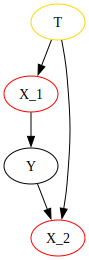

In [24]:
g = gr.Digraph()

g.edge("T", "X_1"), g.node("T", color="gold"), g.edge("X_1", "Y"), g.node("X_1", color="red")
g.edge("T", "X_2"), g.edge("Y", "X_2"), g.node("X_2", color="red")

g

## 核心要点

在本节中，我们探讨了非混淆变量的情况，以及是否应将它们加入因果识别模型。我们发现，即使某些变量不预测处理$T$（即非混淆变量），若它们能良好预测结果 $y$，也应纳入模型。这是因为预测 $Y$ 可降低其方差，从而在估计因果效应时更可能获得统计显著性结果。接着，我们了解到，加入那些仅预测处理而非结果的变量是不明智的。这些变量会减少处理的变异性，加大识别因果效应的难度。最后，我们审视了选择偏误问题——这种偏误源于控制了从处理到结果的因果路径中的变量，或是处理与结果的共同效应变量。




## 参考文献
我愿将这一系列作品视为对 Joshua Angrist、Alberto Abadie 和 Christopher Walters 杰出计量经济学课程的致敬。第一部分的大部分思想源自他们在美国经济学会授课的内容。在艰难的 2020 年，正是观看他们的课程视频让我保持了理智。

 - [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
 - [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

 我还想引用 Angrist 的精彩著作。它们向我展示了计量经济学（他们称之为“Metrics”）不仅极为实用，而且充满乐趣。
 - [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com)
 - [Mastering ‘Metrics](https://www.masteringmetrics.com)

最后还要感谢 Miguel Hernán 和 Jamie Robins 的[《Causal Inference》](https://hsph.harvard.edu/profile/miguel-hernan/)一书。它是我在面对最棘手的因果问题时的可靠伙伴。

![img](./images/poetry.png)

## 参与贡献

**《Causal Inference for the Brave and True》** 是一本关于因果推断的开源教材，致力于以经济上可负担、认知上可理解的方式，普及这门“科学的统计基础”。全书基于 Python，仅使用自由开源软件编写，原始英文版本由 [Matheus Facure](https://github.com/matheusfacure) 编写与维护。

本书的中文版由黄文喆与许文立教授合作翻译，并托管在 [GitHub 中文主页](https://github.com/Wenzhe-Huang/python-causality-handbook-zh)。希望本地化的内容能帮助更多中文读者学习和掌握因果推断方法。

如果你觉得这本书对你有帮助，并希望支持该项目，可以前往 [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true) 支持原作者。

如果你暂时不方便进行经济支持，也可以通过以下方式参与贡献：

* 修正错别字
* 提出翻译或表达建议
* 反馈你未能理解的部分内容

欢迎前往英文版或中文版仓库点击 [issues 区](https://github.com/matheusfacure/python-causality-handbook/issues) 或 [中文版 issues 区](https://github.com/Wenzhe-Huang/python-causality-handbook-zh/issues) 提出反馈。

最后，如果你喜欢这本书的内容，也请将其分享给可能感兴趣的朋友，并为项目在 GitHub 上点亮一颗星：[英文版仓库](https://github.com/matheusfacure/python-causality-handbook) / [中文版仓库](https://github.com/Wenzhe-Huang/python-causality-handbook-zh)。